In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import multiprocessing as MP

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
import utils as U
import opt_runs as OR
import opt_model as OM
import decorated_options as Deco

/Users/musically_ut/prog/work/hcml-assgn-2/opt_runs.py:19: UserWarning: broadcast.opt.optimizer was NOT imported. Comparison against method of Karimi et. al. method will not be possible.
  warnings.warn('broadcast.opt.optimizer was NOT imported. '


In [3]:
from importlib import reload

In [4]:
reload(OM)

<module 'opt_model_soln' from '/Users/musically_ut/prog/work/hcml-assgn-2/opt_model_soln.py'>

# Step 1: Create a SimOpts which will generate raw data

In [5]:
src_id = 0

sim_opts_1_follower = OM.SimOpts(
    s=np.asarray([1.0]),
    q=1.0,
    end_time=100,
    
    src_id=src_id,
    other_sources=[
        (
            'Poisson', 
             {
                  'src_id': 1,
                  'seed': 10016,
                  'rate': 1.0
             }
        )
    ],
    sink_ids=[1000],
    edge_list=[(0, 1000), (1, 1000)]
)

In [6]:
wall_mgr = sim_opts_1_follower.create_manager_for_wall()

wall_mgr.run_dynamic()

wall_df = wall_mgr.state.get_dataframe()
num_world_events = wall_df[wall_df.src_id == 1].event_id.nunique()

print('{} is the number of events posted by source with src_id = 1.'
      .format(num_world_events))

101 is the number of events posted by source with src_id = 1.


# Step 2: Simulate the walls along with different strategies for our broadcaster

### RedQueen

In [7]:
%%time

# Single-core version

# opt_performance = []
# for seed in range(1, 101):
#     opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
#     opt_mgr.run_dynamic()
#     opt_df = opt_mgr.state.get_dataframe()
#     num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=src_id)
#     perf = {
#         'type': 'Opt',
#         'seed': seed,
#     }
#     OR.add_perf(perf, opt_df, sim_opts_1_follower)
#     opt_performance.append(perf)
    
# perf_opt = opt_performance[0]
# opt_perf_df = pd.DataFrame(opt_performance)
# mean_num_opt_tweets = opt_perf_df.num_events.mean()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [8]:
%%time

opt_performance = []

def _worker_opt(seed, return_df=False):
    opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
    opt_mgr.run_dynamic()
    opt_df = opt_mgr.state.get_dataframe()
    num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=src_id)
    perf = {
        'type': 'Opt',
        'seed': seed,
    }
    OR.add_perf(perf, opt_df, sim_opts_1_follower)
    
    if return_df:
        return perf, opt_df
    else:
        return perf

with MP.Pool() as pool:
    opt_performance = pool.map(_worker_opt, range(2, 202))
    
perf_opt, opt_df = _worker_opt(seed=1, return_df=True)
opt_perf_df = pd.DataFrame(opt_performance)
mean_num_opt_tweets = opt_perf_df.num_events.mean()

CPU times: user 82.3 ms, sys: 37.7 ms, total: 120 ms
Wall time: 5.95 s


In [9]:
perf_opt

{'type': 'Opt',
 'seed': 1,
 'top_1': 54.945299729180896,
 'avg_rank': 57.257560203959684,
 'r_2': 85.06468362839678,
 'world_events': 101,
 'num_events': 62}

### Poisson

In [10]:
%%time

# Single core version
# poisson_performance = []
# for seed in range(1, 101):
#     poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=mean_num_opt_tweets)
#     poisson_mgr.run_dynamic()
#     poisson_df = poisson_mgr.state.get_dataframe()
#     num_poisson_tweets = U.num_tweets_of(poisson_df, broadcaster_id=src_id)
#     perf = {
#         'type': 'Poisson',
#         'seed': seed,
#     }
#     OR.add_perf(perf, poisson_df, sim_opts_1_follower)
#     poisson_performance.append(perf)
    
# perf_poisson = poisson_performance[17]
# poisson_perf_df = pd.DataFrame(poisson_performance)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [11]:
%%time

def _worker_poisson(seed, return_df=False):
    poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=mean_num_opt_tweets)
    poisson_mgr.run_dynamic()
    poisson_df = poisson_mgr.state.get_dataframe()
    num_poisson_tweets = U.num_tweets_of(poisson_df, broadcaster_id=src_id)
    perf = {
        'type': 'Poisson',
        'seed': seed,
    }
    OR.add_perf(perf, poisson_df, sim_opts_1_follower)
    
    if return_df:
        return perf, poisson_df
    else:
        return perf

with MP.Pool() as pool:
    poisson_performance = pool.map(_worker_poisson, range(2, 202))
    
perf_poisson, poisson_df = _worker_poisson(seed=1, return_df=True)
poisson_perf_df = pd.DataFrame(poisson_performance)

CPU times: user 68.9 ms, sys: 35.5 ms, total: 104 ms
Wall time: 5.73 s


In [12]:
perf_poisson

{'type': 'Poisson',
 'seed': 1,
 'top_1': 37.49929516636634,
 'avg_rank': 154.01954062930275,
 'r_2': 530.3211806270317,
 'world_events': 101,
 'num_events': 59}

### Smart Poisson

In [13]:
# %%time

# Single core version

# smart_performance = []

# for seed in range(1, 101):
#     T = sim_opts_1_follower.end_time

#     rate = mean_num_opt_tweets / non_zero_time_interval
#     sp_mgr = sim_opts_1_follower.create_manager_with_smart_poisson(
#         seed,
#         rate=rate
#     )

#     sp_mgr.run_dynamic()
#     sp_df = sp_mgr.state.get_dataframe()
#     num_sp_tweets = U.num_tweets_of(sp_df, broadcaster_id=src_id)
#     perf = {
#         'type': 'Smart Poisson',
#         'seed': seed,
#     }
#     OR.add_perf(perf, sp_df, sim_opts_1_follower)
#     smart_performance.append(perf)
    
# perf_sp = smart_performance[74]
# smart_perf_df = pd.DataFrame(smart_performance)

In [14]:
%%time

def _worker_smart_poisson(seed, return_df=False):
    T = sim_opts_1_follower.end_time

    rate = (mean_num_opt_tweets - 1) * (num_world_events / T) / (num_world_events - mean_num_opt_tweets + 1)   # Heuristic
    sp_mgr = sim_opts_1_follower.create_manager_with_smart_poisson(
        seed,
        rate=rate
    )

    sp_mgr.run_dynamic()
    sp_df = sp_mgr.state.get_dataframe()
    num_sp_tweets = U.num_tweets_of(sp_df, broadcaster_id=src_id)
    perf = {
        'type': 'Smart Poisson',
        'seed': seed,
    }
    OR.add_perf(perf, sp_df, sim_opts_1_follower)
    
    if return_df:
        return perf, sp_df
    else:
        return perf

with MP.Pool() as pool:
    smart_performance = pool.map(_worker_smart_poisson, range(2, 202))
    
perf_sp, sp_df = _worker_smart_poisson(seed=1, return_df=True)
smart_perf_df = pd.DataFrame(smart_performance)

CPU times: user 81.7 ms, sys: 33.1 ms, total: 115 ms
Wall time: 6.36 s


In [15]:
perf_sp

{'type': 'Smart Poisson',
 'seed': 1,
 'top_1': 60.677245112368325,
 'avg_rank': 58.77660174039865,
 'r_2': 119.9648295407712,
 'world_events': 101,
 'num_events': 68}

## Sanity Check: Number of events

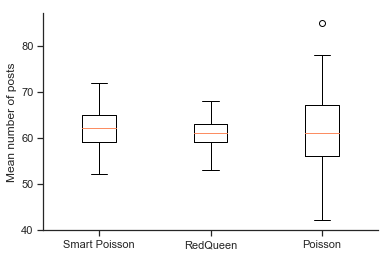

In [16]:
plt.boxplot([smart_perf_df.num_events, opt_perf_df.num_events, poisson_perf_df.num_events])
plt.xticks([1, 2, 3], ['Smart Poisson', 'RedQueen', 'Poisson'])
plt.ylabel('Mean number of posts')
sns.despine()

# Step 3: Study the performance

In [17]:
print('num_opt_tweets = {}, num_poisson_tweets = {}'
      .format(U.num_tweets_of(opt_df, 0), U.num_tweets_of(poisson_df, 0)))

num_opt_tweets = 62.0, num_poisson_tweets = 59.0


In [18]:
print('avg_rank_opt = {}, avg_rank_poisson = {}'
      .format(U.average_rank(opt_df, sim_opts=sim_opts_1_follower), 
              U.average_rank(poisson_df, sim_opts=sim_opts_1_follower)))

avg_rank_opt = 57.257560203959684, avg_rank_poisson = 154.01954062930275


In [19]:
K = 1
print('Time spent in the top-{} by Redqueen = {} and Poisson = {}'
      .format(K, 
              U.time_in_top_k(opt_df, K=K, sim_opts=sim_opts_1_follower),
              U.time_in_top_k(poisson_df, K=K, sim_opts=sim_opts_1_follower)))

Time spent in the top-1 by Redqueen = 54.945299729180896 and Poisson = 37.49929516636634


### Plot evolution

In [20]:
def plot_rank_evolution(df, src_id):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    ranks = U.rank_of_src_in_df(df, src_id).mean(axis=1)
    
    fig, ax1 = plt.subplots()
    
    ax1.fill_between(ranks.index, ranks.values, step='post',
                     color=c1, label=r'$\bar{r}(t)$', alpha=0.5)
    
    ax1.set_ylabel('Rank')
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    ax1.set_ylim(0)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    plt.tight_layout()

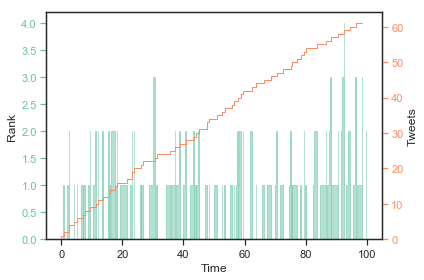

In [21]:
plot_rank_evolution(opt_df, src_id)

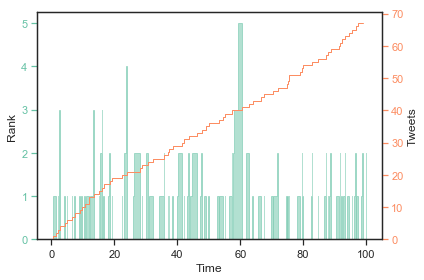

In [22]:
plot_rank_evolution(sp_df, src_id)

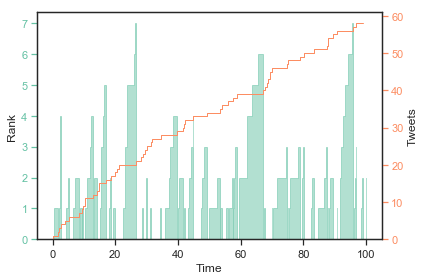

In [23]:
plot_rank_evolution(poisson_df, src_id)

In [24]:
def plot_top_k_evolution(df, src_id, K=1, T=100, ymax=None):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    top_k = (U.rank_of_src_in_df(df, src_id) < K).mean(axis=1)
    
    times = np.asarray([0] + top_k.index.values.tolist() + [T])
    t_diff = np.diff(times)
    top_k_indicator = np.array([0] + top_k.values.tolist())

    fig, ax1 = plt.subplots()    

    ax1.fill_between(times[:-1], np.cumsum(top_k_indicator * t_diff), step='post',
                     color=c1, label=r'$1_{[r(t) <= %d]}$' % K,
                     alpha=0.5)
    
    ax1.set_ylabel('Time in Top-{}'.format(K))
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    
    if ymax is None:
        ax1.set_ylim(0)
    else:
        ax1.set_ylim(0, ymax)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    # plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    plt.tight_layout()

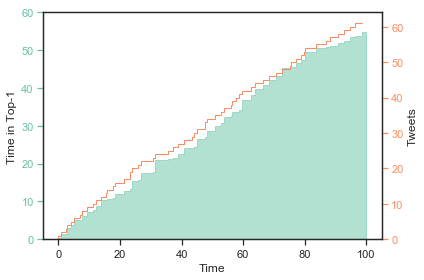

In [25]:
plot_top_k_evolution(opt_df, src_id, ymax=60)

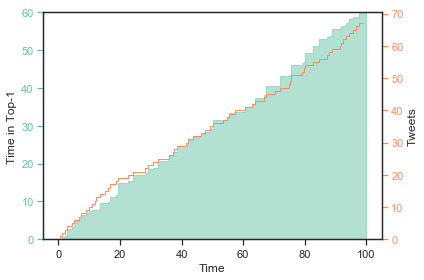

In [26]:
plot_top_k_evolution(sp_df, src_id, ymax=60)

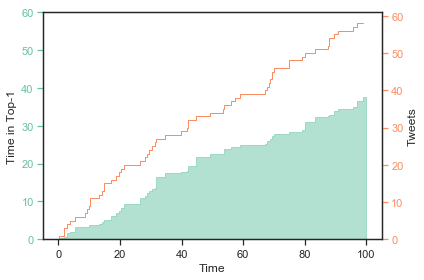

In [27]:
plot_top_k_evolution(poisson_df, src_id, ymax=60)

# Average performance

In [28]:
poisson_perf_df.describe()

,avg_rank,num_events,r_2,seed,top_1,world_events
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,155.932477,61.225000,571.031466,101.500000,35.225770,101.0
std,28.594674,7.966284,226.562396,57.879185,4.536139,0.0
min,99.354043,42.000000,254.188284,2.000000,23.853671,101.0
25%,135.165892,56.000000,414.117484,51.750000,32.154930,101.0
50%,152.555862,61.000000,532.836052,101.500000,35.214029,101.0
75%,170.953026,67.000000,643.157676,151.250000,38.346952,101.0
max,255.064382,85.000000,1406.766923,201.000000,46.199658,101.0


In [29]:
opt_perf_df.describe()

,avg_rank,num_events,r_2,seed,top_1,world_events
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,59.071768,60.780000,98.697205,101.500000,56.917900,101.0
std,5.299489,3.054217,12.948203,57.879185,3.285566,0.0
min,45.185855,53.000000,64.974322,2.000000,47.571958,101.0
25%,54.999334,59.000000,89.454896,51.750000,54.423356,101.0
50%,59.015459,61.000000,98.254762,101.500000,56.950706,101.0
75%,62.613485,63.000000,108.016309,151.250000,59.303826,101.0
max,73.991925,68.000000,138.973145,201.000000,63.764033,101.0


In [30]:
smart_perf_df.describe()

,avg_rank,num_events,r_2,seed,top_1,world_events
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,67.475319,62.020000,144.964624,101.500000,57.592723,101.0
std,9.407538,3.586631,39.954203,57.879185,3.651869,0.0
min,48.399956,52.000000,78.293115,2.000000,44.503015,101.0
25%,60.855162,59.000000,117.320903,51.750000,55.326143,101.0
50%,67.426350,62.000000,139.049889,101.500000,57.495456,101.0
75%,72.232243,65.000000,163.802688,151.250000,60.215947,101.0
max,107.862534,72.000000,302.744919,201.000000,67.202387,101.0
